<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/Local_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 1

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]
  return np.array(outputMatrix)

In [ ]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [ ]:
def find_nearest(matrix, lista, unvisited):
    df = matrix[:, lista][unvisited, :]
    indx, indy = np.unravel_index(df.argmin(), df.shape)
    return unvisited[indx], lista[indy]

In [ ]:
def random_heuristic(matrix, start):
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

In [ ]:
def nearest_neighbor(matrix, start):
    end = np.argmax(matrix[start, :])
    unvisited = list(range(matrix.shape[0]))
    unvisited.remove(start)
    unvisited.remove(end)
    list1 = [start]
    list2 = [end]
    while len(unvisited) != 0:
        nearest, vertex = find_nearest(matrix, list1, unvisited)
        list1.insert(list1.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
        if len(unvisited) == 0:
          break
        nearest, vertex = find_nearest(matrix, list2, unvisited)
        list2.insert(list2.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [ ]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0].insert(x, c)
        else:
            cycles[1].insert(x, c)

    return cycles

In [ ]:
def two_regret(matrix, start_node):
    start_node_2 = np.argmax(matrix[start_node])

    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]
        z = -np.inf
        x = np.inf
        c = np.inf
        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            values = {}
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                values.update({j:value})
            values = dict(sorted(values.items(), key= lambda x:x[1]))
            keys = list(values.keys())
            value = values[keys[1]] - 1.5*values[keys[0]]
            if value > z:
                z = value
                x = keys[0] + 1
                c = nearest

            
        if len(cycles[0]) <= len(cycles[1]):
                cycles[0].insert(x, c)
        else:
                cycles[1].insert(x, c)

    return cycles

In [ ]:
def draw_plot(vertices, visited, length, filename):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def draw_best(ver_data, lengths, heuris, filename):
  best_start_node = np.argmin(lengths)
  distance_matrix = createDistanceMatrix(ver_data)
  vertexes = heuris(distance_matrix, best_start_node)
  min_length = lengths[best_start_node]
  draw_plot(ver_data, vertexes, min_length, filename)

In [ ]:
def test(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [ ]:
#Four heuris to choose: random_heuristic, nearest_neighbor, greedyCycle, two_regret 
lengths = test(100, heuris = two_regret,ver_data =  ver_data)
print(f'{round(sum(lengths)/len(lengths))} ({min(lengths)}-{max(lengths)})')

26550 0
26336 3
24586 4
24380 5
24329 10
23619 20
23546 22
26900 (23546-30422)


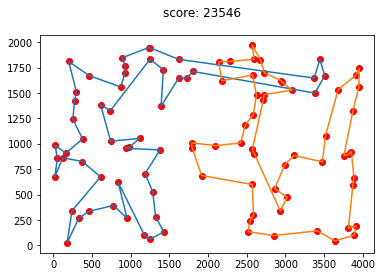

In [ ]:
draw_best(ver_data, lengths, greedyCycle, 'cycleB')

# LAB 2

## Tworzenie możliwych ruchów dla podanego wierzchołka

In [ ]:
def swap_vertex(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["vertex"]*(n), copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_vertex_cycle(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  return list(zip(["cycle"]*n, copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_edges(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["edges"]*(n), copy, [vertex]*(n),  [i]*(n)))

## Obliczanie delty funkcji celu

In [ ]:
def calculate_delta(typ, distance_matrix, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig1+2], list1[min1]]+ distance_matrix[
                                                          list1[neig2], list1[max1]] + distance_matrix[list1[neig2-2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig1+2], list1[max1]]+ distance_matrix[
                                                          list1[neig2], list1[min1]] + distance_matrix[list1[neig2-2], list1[min1]]
    if abs(ind1-ind2)==1 or neig2==min1:
      delta2+=2*distance_matrix[list1[ind1], list1[ind2]]


  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    if neig2==0 and min1==0:
      return 0
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig2], list1[min1]]

  elif typ=="cycle":
    if list_of_vertex2:
      list2 = list_of_vertex2[:-1]
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    indout1 = (ind1+1)%len(list1)
    indout2 = (ind2+1)%len(list2)
    delta1 = distance_matrix[list1[ind1-1], list1[ind1]] + distance_matrix[list1[indout1], list1[ind1]]+ distance_matrix[
                                                          list2[ind2-1], list2[ind2]] + distance_matrix[list2[indout2], list2[ind2]]
    delta2 = distance_matrix[list1[ind1-1], list2[ind2]] + distance_matrix[list1[indout1], list2[ind2]]+ distance_matrix[
                                                          list2[ind2-1], list1[ind1]] + distance_matrix[list2[indout2], list1[ind1]]
  return delta2-delta1

## Wykonywanie ruchu

In [ ]:
def move(typ, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  list2 = list_of_vertex2[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    list1[ind1], list1[ind2] = list1[ind2], list1[ind1] 

  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1, ind2)
    list1[min1:max1+1] = reversed(list1[min1:max1+1])

  else:
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    list1[ind1], list2[ind2] = list2[ind2], list1[ind1]
    

  list1.append(list1[0])
  list2.append(list2[0])
  return list1, list2


## Algorytmy wykorzystane do rozwiązania zadania

In [ ]:
def steepest(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      delta = 0
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)

      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < delta:
          best_move = m
          delta = new_delta

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), delta)
          print()
      else:
        break
      

  return start_solution


In [ ]:
def greedy(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < 0:
          best_move = m
          break

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), new_delta)
          print()
      else:
        break
      

  return start_solution

In [ ]:
def random_wandering(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  j = 0
  while j<100:
      j+=1
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      m = moves[random.randint(0, len(moves)-1)]
      i = m[3]
      new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
      if new_delta < 0:
        best_move = m

      if best_move:
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution))
          print()
      
      

  return start_solution

time: 27.8 ms (started: 2022-04-03 12:43:20 +00:00)


## Uruchamianie eksperymentów

In [ ]:
def test_lab2(n, heuris, ver_data, algor = steepest, swap = swap_vertex):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  best_length = np.inf
  best = None
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    vertexes = algor(distance_matrix, swap, start_solution = vertexes, verbose = False)
    length = calculateCycleLength(distance_matrix, vertexes)
    if length < best_length:
      best = vertexes
      best_length = length
    lengths.append(length)
  return lengths, best, best_length

In [ ]:
def draw_best2(ver_data, best, length, filename = "cos"):
  for graph in best:
    x = ver_data[graph, 0]
    y = ver_data[graph,1]
    plt.plot(x, y)
  plt.scatter(ver_data[:, 0], ver_data[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')

In [ ]:
#load time measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

time: 6.98 ms (started: 2022-04-03 13:33:01 +00:00)


In [ ]:
# algor to choose: steepest, greedy or random_wandering, swap: swap_edges or swap_vertex
lengt, best, bl = test_lab2(100, two_regret, ver_data, algor = steepest, swap = swap_edges)

time: 3min 10s (started: 2022-04-03 13:33:03 +00:00)


In [ ]:
print(f'{round(sum(lengt)/len(lengt))} ({min(lengt)}-{max(lengt)})')

24179 (22534-27517)
time: 2.58 ms (started: 2022-04-03 13:49:30 +00:00)


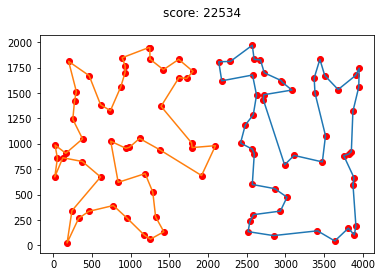

time: 703 ms (started: 2022-04-03 13:49:39 +00:00)


In [ ]:
draw_best2(ver_data, best, bl, filename="steepest")

# LAB 3

In [ ]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint
import time

In [ ]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA200.tsp')
kroBProblem = tsplib95.load('kroB200.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

In [ ]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [ ]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [ ]:
def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def random_heuristic(matrix, start):
    import random
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

## Ruchy kandydackie

In [ ]:
def find_cycle(cycles, a):
    if a in cycles[0]:
      return 0, cycles[0].index(a)
    return 1, cycles[1].index(a)

def reverse(cycle, i, j):
    n = len(cycle)
    d = (j - i) % n
    for k in range(d//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        cycle[a], cycle[b] = cycle[b], cycle[a]

def calculate_delta(typ, matrix, a, b, cycle1, cycle2, i, j):
    if typ == "edges":
      n = len(cycle1)
      a, b, c, d = a, cycle1[(i+1)%n], b, cycle1[(j+1)%n]
      return matrix[a, c] + matrix[b, d] - matrix[a, b] - matrix[c, d]
    elif typ=="cycles":
      n, m = len(cycle1), len(cycle2)
      x1, y1, z1 = cycle1[(i-1)%n], cycle1[i], cycle1[(i+1)%n]
      x2, y2, z2 = cycle2[(j-1)%m], cycle2[j], cycle2[(j+1)%m]
      return matrix[x1,y2] + matrix[z1,y2] - matrix[x1,y1] - matrix[z1,y1] + matrix[x2,y1] + matrix[z2,y1] - matrix[x2,y2] - matrix[z2,y2]


def move(typ, a, b, cycles):
    if typ == "edges":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif typ == "cycles":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]


In [ ]:
def steepest_candidate_movements(matrix, visited_1, visited_2, k=10):
    N = len(matrix)
    cycles = [visited_1, visited_2]

    while True:
        best_move, best_delta = None, 0
        for a in range(N):
            for b in np.argpartition(matrix[a], k+1)[:k+1]:
                if a == b:
                  continue

                c1, i = find_cycle(cycles, a)
                c2, j = find_cycle(cycles, b)
                M, delta = None, None
                if c1 == c2:
                    delta = calculate_delta("edges", matrix, a, b, cycles[c1], None, i, j)
                    M = a, b, "edges"
                else:
                    delta = calculate_delta("cycles", matrix, a, b, cycles[c1], cycles[c2], i, j)
                    M = a, b, "cycles"
                if delta < best_delta:
                    best_delta, best_move = delta, M
                    
        if best_move is None:
            break
        a, b, typ = best_move
        move(typ, a, b, cycles)
            
    return cycles[0], cycles[1]

## Lokalne przeszukiwania z listą ruchów przynoszących poprawę


In [ ]:
def is_edge(cycle, a, b):
  if a in cycle and b in cycle:
    return cycle.index(b) - cycle.index(a) if abs(cycle.index(b) - cycle.index(a))==1 else 0
  return False

def start_moves(matrix, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i in range(n):
            for j in range(i+1, n):
              delta = calculate_delta("edges",matrix, cycle[i], cycle[j], cycle, None, i, j)
              if delta<0:
                moves.append([delta, cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n], "edges"])

    for i in range(len(cycles[0])):
      for j in range(len(cycles[1])):
        delta = calculate_delta("cycles",matrix, cycles[0][i], cycles[1][j], cycles[0], cycles[1], i, j)
        if delta<0:
          n, m = len(cycles[0]), len(cycles[1])
          x1, y1, z1 = cycles[0][(i-1)%n], cycles[0][i], cycles[0][(i+1)%n]
          x2, y2, z2 = cycles[1][(j-1)%m], cycles[1][j], cycles[1][(j+1)%m]
          moves.append([delta, 0, 1, x1, y1, z1, x2, y2, z2, "cycles"])
    return moves
 



def next_moves(matrix, cycles, typ, a, b):
    moves = []
    if typ == "edges":
        cycle = cycles[0] if a in cycles[0] else cycles[1]
        n = len(cycle)
        I = cycle.index(a)
        for i in range(I, n):
          for j in range(i+1, n):
            delta = calculate_delta("edges",matrix, cycle[i], cycle[j], cycle, None, i, j)
            if delta<0:
              moves.append([delta, cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n], "edges"])
            delta = calculate_delta("edges",matrix, cycle[j], cycle[i], cycle, None, j, i)
            if delta<0:
              moves.append([delta, cycle[j], cycle[(j+1)%n], cycle[i], cycle[(i+1)%n], "edges"])

    elif typ == "cycles":
        (c1, i), (c2, j) = find_cycle(cycles, a), find_cycle(cycles, b)
        n, m = len(cycles[c1]), len(cycles[c2])
        for k in range(m):
            delta = calculate_delta("cycles",matrix, a, cycles[c2][k], cycles[c1], cycles[c2], i, k)
            if delta<0:
              x1, y1, z1 = cycles[c1][(i-1)%n], cycles[c1][i], cycles[c1][(i+1)%n]
              x2, y2, z2 = cycles[c2][(k-1)%m], cycles[c2][k], cycles[c2][(k+1)%m]
              moves.append([delta, c1, c2, x1, y1, z1, x2, y2, z2, "cycles"])
        for k in range(n):
            delta = calculate_delta("cycles",matrix, b, cycles[c1][k], cycles[c2], cycles[c1], j, k)
            if delta<0:
              x1, y1, z1 = cycles[c2][(j-1)%n], cycles[c2][j], cycles[c2][(j+1)%n]
              x2, y2, z2 = cycles[c1][(k-1)%m], cycles[c1][k], cycles[c1][(k+1)%m]
              moves.append([delta, c2, c1, x1, y1, z1, x2, y2, z2, "cycles"])
    return moves

time: 83.1 ms (started: 2022-05-11 12:46:53 +00:00)


In [ ]:
def steepest_list_better_moves(matrix, cycles):
    moves = sorted(start_moves(matrix, cycles), key=lambda x: x[0])

    while True:
        to_remove = []
        best_move = None
        for k, M in enumerate(moves):

            if M[-1] == "edges":
                _, a, b, c, d, _ = M

                c1, s1, c2, s2 = None, False, None, False

                for i in range(2):
                  status = is_edge(cycles[i], a, b)
                  if status: 
                    c1, s1 = i, status
                
                
                for i in range(2):
                  status = is_edge(cycles[i], c, d)
                  if status: 
                    c2, s2 = i, status

                if c1 != c2 or False in [s1,s2]:
                    to_remove.append(k)
                elif s1 == s2 == 1:
                    to_remove.append(k)
                    best_move = a, c, "edges"
                    break
                elif s1 == s2 == -1:
                    to_remove.append(k)
                    best_move = b, d, "edges"
                    break


            elif M[-1] == "cycles":
                _, c1, c2, a, b, c, d, e, f, _ = M
                S = [[c1, a, b], [c1, b, c], [c2, d, e], [c2, e, f]]
                s = []
                for s in S:
                  s.append(is_edge(cycles[s[0]], s[1], s[2]))
                
                if c1 == c2 or False in s:
                    to_remove.append(k)
                elif s[0] == s[1] and s[2] == s[3]:
                    to_remove.append(k)
                    best_move = b, e, "cycles"
                    break
                
        if best_move is None:
            break
            
        for i in reversed(to_remove):
          del(moves[i])

        a, b, typ = best_move

        move(typ, a, b, cycles)
        new_moves = next_moves(matrix, cycles, typ, a, b)
       
        moves.extend(new_moves)
        moves = sorted(moves, key=lambda x: x[0])
  
        
    return cycles

time: 79 ms (started: 2022-05-11 12:22:22 +00:00)


## Testowanie algorytmów

In [ ]:
#load time measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
version = verticesA
matrix = distance_matrix(version)
best_sum = np.inf
best = None
sums = []

for i in range(100):
  start_node_1 = i
  visited_1, visited_2 = random_heuristic(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_list_better_moves(matrix, [visited_1, visited_2])
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum

print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(version, best, min(sums), "lepszeRuchyA")



In [ ]:
version = verticesB
matrix = distance_matrix(version)
best_sum = np.inf
best = None
sums = []
for i in range(100):
  start_node_1 = i
  visited_1, visited_2 = random_heuristic(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_candidate_movements(matrix, visited_1, visited_2)
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum
    


print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(version, best, min(sums), "kandydackiB")


# LAB 4

## MSLS

In [ ]:
from random import randint
def multiple_start_local_search(matrix, numIteration = 100):
  i = 0
  global_sum = np.inf
  final_visited_1, final_visited_2 = [], []
  
  # stop condition => 100 iterations
  pbar = tqdm(total=numIteration)
  while i < numIteration:
    pbar.update(1)
    # generate random start solution
    start_vertice = randint(0, len(matrix) - 1)
    [visited_1, visited_2] = random_heuristic(matrix, start_vertice)

    # Local search 
    # steepest_change_vertices(matrix, visited_1, visited_2)
    visited_1, visited_2 = greedy(matrix, start_solution = [visited_1, visited_2], verbose = False)
    sum = calculateCycleLength(matrix, [visited_1, visited_2])

    # check if it's better than last
    if (sum < global_sum):
      global_sum = sum
      final_visited_1, final_visited_2 = visited_1, visited_2

    i += 1
  pbar.close()

  return final_visited_1, final_visited_2

time: 588 µs (started: 2022-05-15 22:07:13 +02:00)


## ILS

In [ ]:
def change_solution(visited_1, visited_2):
  first = randint(0, len(visited_1) - 1)
  second = randint(0, len(visited_2) - 1)

  visited_1[first], visited_2[second] = visited_2[second], visited_1[first]

  return visited_1, visited_2

In [ ]:
def check_for_best_move(matrix, item, visited):
  min_value = np.inf
  min_index = None

  for i, vertex in enumerate(visited[0:-1]):
    temp_sum = matrix[vertex][item] + matrix[visited[i + 1]][item]

    if temp_sum < min_value:
      min_value = temp_sum
      min_index = i + 1

  return min_index

In [ ]:
def rebuilt_solution(matrix, visited_1, visited_2, deleted_vertices):

  if visited_1[0] != visited_1[-1]:
    visited_1 = np.append(visited_1, visited_1[0])

  if visited_2[0] != visited_2[-1]:
    visited_2 = np.append(visited_2, visited_2[0])

  for elem in deleted_vertices:
    if len(visited_2) < len(visited_1):
      visited_2 = np.insert(visited_2, check_for_best_move(matrix, elem, visited_2), elem)
    else:
      visited_1 = np.insert(visited_1, check_for_best_move(matrix, elem, visited_1), elem)
  
  return visited_1, visited_2

## ILS1

In [ ]:
def iterated_start_local_search_1(matrix, iterationNumChange=5, avgTime=919.5): # 9.5): # 
  
  start_vertice = randint(0, len(matrix) - 1)
  [visited_1, visited_2] = random_heuristic(matrix, start_vertice)
  steepest(matrix, start_solution=[visited_1, visited_2], verbose=False)
  global_sum = calculateCycleLength(matrix, [visited_1, visited_2])


  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)

    # simple perturabtion
    for i in range(0, iterationNumChange):
      temp_visited_1, temp_visited_2 = change_solution(temp_visited_1, temp_visited_2)

    # Local Search
    temp_visited_1, temp_visited_2 = greedy(matrix, start_solution=[temp_visited_1, temp_visited_2], verbose=False)
    #steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    
    sum = calculateCycleLength(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
  return visited_1, visited_2

## ILS 2

In [ ]:
def iterated_start_local_search_2(matrix, rebuildSize = 0.2, avgTime = 919.5):
  if rebuildSize > 1.0:
    print('Error rebuilt size must be <= 1.')
    rebuildSize = 0.2
 
  start_vertice = randint(0, len(matrix) - 1)
  visited_1, visited_2 = random_heuristic(matrix, start_vertice)
  # steepest_change_vertices(matrix, visited_1, visited_2)
  global_sum = calculateCycleLength(matrix, [visited_1, visited_2])

  start = time()
  end = 0

  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)
    deleted_vertices = []

    # destroy solution - perturbacja
    while len(temp_visited_1) + len(temp_visited_2) >= (1 - rebuildSize) * len(matrix):
      if len(temp_visited_1) > len(temp_visited_2): 
        delete_vertice = randint(0, len(temp_visited_1) - 1)
        deleted_vertices.append(temp_visited_1[delete_vertice])
        temp_visited_1 = np.delete(temp_visited_1, delete_vertice)

      else:
        delete_vertice = randint(0, len(temp_visited_2) - 1)
        deleted_vertices.append(temp_visited_2[delete_vertice])
        temp_visited_2 = np.delete(temp_visited_2, delete_vertice)

    # repair solution
    temp_visited_1, temp_visited_2 = rebuilt_solution(matrix, temp_visited_1, temp_visited_2, deleted_vertices)

    # Local Search
    # steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    temp_visited_1, temp_visited_2 = greedy(matrix, start_solution=[temp_visited_1, temp_visited_2], verbose=False)
    
    sum = calculateCycleLength(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
    end = time()
    
  return visited_1, visited_2